In [1]:
# This script is basically CovaPT's jupyter notebook, but in script form so you can more easily run it
%matplotlib inline
import scipy, time,sys, warnings, math
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
from scipy.interpolate import InterpolatedUnivariateSpline
from numpy import exp, log, log10, cos, sin, pi, cosh, sinh , sqrt, amin, amax, mean, dot, power, conj
from scipy.misc import derivative
import camb
from camb import model, initialpower
from classy import Class
#from ctypes import c_double, c_int, cdll, byref
sys.path.append('/home/joeadamo/Research') #<- parent directory of dark emulator code
from DarkEmuPowerRSD import pkmu_nn, pkmu_hod
from itertools import repeat
sys.path.append('/home/joeadamo/Research/Software')
from pk_tools import pk_tools

sys.path.insert(0, '/home/u12/jadamo/CovaPT/detail')
sys.path.insert(0, '/home/joeadamo/Research/CovaPT/detail')
import T0

In [2]:
#-------------------------------------------------------------------
# GLOBAL VARIABLES
#-------------------------------------------------------------------

# dire='/home/u12/jadamo/CovaPT/Example-Data/'
# home_dir = "/home/u12/jadamo/CovA-NN-Emulator/Training-Set/"
dire='/home/joeadamo/Research/CovaPT/Example-Data/'
home_dir = "/home/joeadamo/Research/CovNet/Data/PCA-Set/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/"

#Using the window kernels calculated from the survey random catalog as input
#See Survey_window_kernels.ipynb for the code to generate these window kernels using the Wij() function
# The survey window used throughout this code is BOSS NGC-highZ (0.5<z<0.75)
WijFile=np.load(dire+'Wij_k120_HighZ_NGC.npy')

# Loading window power spectra calculated from the survey random catalog (code will be uploaded in a different notebook)
# These are needed to calculate the sigma^2 terms
# Columns are k P00 P02 P04 P22 P24 P44 Nmodes
powW22=np.loadtxt(dire+'WindowPower_W22_highz.dat')
powW10=np.loadtxt(dire+'WindowPower_W10_highz.dat')

# Columns are k P00 P02 P04 P20 P22 P24 P40 P42 P44 Nmodes
powW22x10=np.loadtxt(dire+'WindowPower_W22xW10_highz.dat')

kbins=25

# The following parameters are calculated from the survey random catalog
# Using Iij convention in Eq.(3)
alpha = 0.02; 
i22 = 454.2155*alpha; i11 = 7367534.87288*alpha; i12 = 2825379.84558*alpha;
i10 = 23612072*alpha; i24 = 58.49444652*alpha; 
i14 = 756107.6916375*alpha; i34 = 8.993832235e-3*alpha;
i44 = 2.158444115e-6*alpha; i32 = 0.11702382*alpha;
i12oi22 = 2825379.84558/454.2155; #Effective shot noise

gparams = {'logMmin': 13.9383, 'sigma_sq': 0.7918725**2, 'logM1': 14.4857, 'alpha': 1.19196,  'kappa': 0.600692, 
          'poff': 0.0, 'Roff': 2.0, 'alpha_inc': 0., 'logM_inc': 0., 'cM_fac': 1., 'sigv_fac': 1., 'P_shot': 0.}

In [3]:
#-------------------------------------------------------------------
# FUNCTIONS
#-------------------------------------------------------------------

#-------------------------------------------------------------------
# For generating individual elements of the Gaussian covariance matrix
# see Survey_window_kernels.ipynb for further details where the same function is used
def Cij(kt, Wij, Pfit):
    temp=np.zeros((7,6));
    for i in range(-3,4):
        if(kt+i<0 or kt+i>=kbins):
            temp[i+3]=0.
            continue
        temp[i+3]=Wij[i+3,0]*Pfit[0][kt]*Pfit[0][kt+i]+\
        Wij[i+3,1]*Pfit[0][kt]*Pfit[2][kt+i]+\
        Wij[i+3,2]*Pfit[0][kt]*Pfit[4][kt+i]+\
        Wij[i+3,3]*Pfit[2][kt]*Pfit[0][kt+i]+\
        Wij[i+3,4]*Pfit[2][kt]*Pfit[2][kt+i]+\
        Wij[i+3,5]*Pfit[2][kt]*Pfit[4][kt+i]+\
        Wij[i+3,6]*Pfit[4][kt]*Pfit[0][kt+i]+\
        Wij[i+3,7]*Pfit[4][kt]*Pfit[2][kt+i]+\
        Wij[i+3,8]*Pfit[4][kt]*Pfit[4][kt+i]+\
        1.01*(Wij[i+3,9]*(Pfit[0][kt]+Pfit[0][kt+i])/2.+\
        Wij[i+3,10]*Pfit[2][kt]+Wij[i+3,11]*Pfit[4][kt]+\
        Wij[i+3,12]*Pfit[2][kt+i]+Wij[i+3,13]*Pfit[4][kt+i])+\
        1.01**2*Wij[i+3,14]
    return(temp)

#-------------------------------------------------------------------
# Growth factor for LCDM cosmology
def Dz(z,Om0):
    return(scipy.special.hyp2f1(1/3., 1, 11/6., (1-1/Om0)/(1+z)**3)
                                /scipy.special.hyp2f1(1/3., 1, 11/6., 1-1/Om0)/(1+z))

#-------------------------------------------------------------------
# Growth rate for LCDM cosmology
def fgrowth(z,Om0):
    return(1. + 6*(Om0-1)*scipy.special.hyp2f1(4/3., 2, 17/6., (1-1/Om0)/(1+z)**3)
                  /( 11*Om0*(1+z)**3*scipy.special.hyp2f1(1/3., 1, 11/6., (1-1/Om0)/(1+z)**3) ))

In [4]:
#-------------------------------------------------------------------
def Pk_lin(H0, ombh2, omch2, As, ns, z, k):
    """
    Generates a linear initial power spectrum from CAMB
    """
    #get matter power spectra and sigma8 at the redshift we want
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(ns=ns, As=np.exp(As)/1e10)
    #Note non-linear corrections couples to smaller scales than you want
    pars.set_matter_power(redshifts=[z], kmax=np.amax(k))

    #Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    # k bins will be interpolated to what we want later, so it's "ok" if this isn't exact
    kh, z1, pk = results.get_matter_power_spectrum(minkh=np.amin(k)/2., maxkh=np.amax(k), npoints = 20*len(k))
    
    pdata = np.vstack((kh, pk[0])).T
    return pdata

def Pk_gg(H0, omch2, ombh2, As, pgg):
    """
    Calculates the galaxy power spectrum using Yosuke's dark emulator
    """
    #print(params)
    h = H0 / 100
    #assert As >= 2.47520
    ns = 0.965
    Om0 = (omch2 + ombh2 + 0.00064) / (h**2)
    
    # rebuild parameters into correct format (ombh2, omch2, 1-Om0, ln As, ns, w)
    cparams = np.array([ombh2, omch2, 1-Om0, As, ns, -1])
    redshift = 0.58
    k = np.linspace(0.005, 0.25, 50)
    #mu = np.linspace(0.1,0.9,4)
    alpha_perp = 1.1 #<-these vary with cosmology
    alpha_para = 1

    pgg.set_cosmology(cparams, redshift) # <- takes ~0.17s to run
    pgg.set_galaxy(gparams)
    # takes ~0.28 s to run
    P0_emu = pgg.get_pl_gg_ref(0, k, alpha_perp, alpha_para, name='total')
    P2_emu = pgg.get_pl_gg_ref(2, k, alpha_perp, alpha_para, name='total')
    P4_emu = pgg.get_pl_gg_ref(4, k, alpha_perp, alpha_para, name='total')
    return [P0_emu, 0, P2_emu, 0, P4_emu]

def Pk_CLASS_PT(params, k):
    z = 0.61
    cosmo = Class()
    cosmo.set({'output':'mPk',
            'non linear':'PT',
            'IR resummation':'Yes',
            'Bias tracers':'Yes',
            'cb':'Yes', # use CDM+baryon spectra
            'RSD':'Yes',
            'AP':'Yes', # Alcock-Paczynski effect
            'Omfid':'0.31', # fiducial Omega_m
            'PNG':'No', # single-field inflation PNG
            #'FFTLog mode':'FAST',
            'A_s':np.exp(params[3])/1e10,
            'n_s':params[4],
            'tau_reio':0.052,
            'omega_b':params[2],
            'omega_cdm':params[1],
            'h':params[0] / 100.,
            'YHe':0.2425,
            'N_ur':2.0328,
            'N_ncdm':1,
            'm_ncdm':0.06,
            'z_pk':z
            })  
    cosmo.compute()
    cosmo.initialize_output(k, z, len(k))

    b1, b2, bG2, bGamma3, cs0, cs2, cs4, Pshot, b4 = params[5], params[6], 0.1, -0.1, 0., 30., 0., 3000., 10.
    pk_g0 = cosmo.pk_gg_l0(b1, b2, bG2, bGamma3, cs0, Pshot, b4)
    pk_g2 = cosmo.pk_gg_l2(b1, b2, bG2, bGamma3, cs2, b4)
    pk_g4 = cosmo.pk_gg_l4(b1, b2, bG2, bGamma3, cs4, b4)
    cosmo.struct_cleanup()
    return [pk_g0, 0, pk_g2, 0, pk_g4]

In [5]:
#-------------------------------------------------------------------
def trispIntegrand(u12,k1,k2,Plin):
    return( (8*i44*(Plin(k1)**2*T0.e44o44_1(u12,k1,k2) + Plin(k2)**2*T0.e44o44_1(u12,k2,k1))
            +16*i44*Plin(k1)*Plin(k2)*T0.e44o44_2(u12,k1,k2)
             +8*i34*(Plin(k1)*T0.e34o44_2(u12,k1,k2)+Plin(k2)*T0.e34o44_2(u12,k2,k1))
            +2*i24*T0.e24o44(u12,k1,k2))
            *Plin(np.sqrt(k1**2+k2**2+2*k1*k2*u12)) )

#-------------------------------------------------------------------
# Returns the tree-level trispectrum as a function of multipoles and k1, k2
def trisp(l1,l2,k1,k2, Plin):
    T0.l1=l1; T0.l2=l2
    expr = i44*(Plin(k1)**2*Plin(k2)*T0.ez3(k1,k2) + Plin(k2)**2*Plin(k1)*T0.ez3(k2,k1))\
           +8*i34*Plin(k1)*Plin(k2)*T0.e34o44_1(k1,k2)
    temp = (quad(trispIntegrand, -1, 1,args=(k1,k2,Plin), limit=100)[0]/2. + expr)/i22**2
    return(temp)
trisp = np.vectorize(trisp)

#-------------------------------------------------------------------
# Using the Z12 kernel which is defined in Eq. (A9) (equations copy-pasted from Generating_T0_Z12_expressions.nb)
def Z12Kernel(l,mu,be,b1,b2,g2,dlnpk):
    if(l==0):
        exp=(7*b1**2*be*(70 + 42*be + (-35*(-3 + dlnpk) + 3*be*(28 + 13*be - 14*dlnpk - 5*be*dlnpk))*mu**2) + 
            b1*(35*(47 - 7*dlnpk) + be*(798 + 153*be - 98*dlnpk - 21*be*dlnpk + 
            4*(84 + be*(48 - 21*dlnpk) - 49*dlnpk)*mu**2)) + 
            98*(5*b2*(3 + be) + 4*g2*(-5 + be*(-2 + mu**2))))/(735.*b1**2)
    elif(l==2):
        exp=(14*b1**2*be*(14 + 12*be + (2*be*(12 + 7*be) - (1 + be)*(7 + 5*be)*dlnpk)*mu**2) + 
            b1*(4*be*(69 + 19*be) - 7*be*(2 + be)*dlnpk + 
            (24*be*(11 + 6*be) - 7*(21 + be*(22 + 9*be))*dlnpk)*mu**2 + 7*(-8 + 7*dlnpk + 24*mu**2)) + 
            28*(7*b2*be + g2*(-7 - 13*be + (21 + 11*be)*mu**2)))/(147.*b1**2)
    elif(l==4):
        exp=(8*be*(b1*(-132 + 77*dlnpk + be*(23 + 154*b1 + 14*dlnpk)) - 154*g2 + 
            (b1*(396 - 231*dlnpk + be*(272 + 308*b1 + 343*b1*be - 7*(17 + b1*(22 + 15*be))*dlnpk)) + 
            462*g2)*mu**2))/(2695.*b1**2)
    return(exp)

#-------------------------------------------------------------------
# Legendre polynomials
def lp(l,mu):
    if (l==0): exp=1
    if (l==2): exp=((3*mu**2 - 1)/2.)
    if (l==4): exp=((35*mu**4 - 30*mu**2 + 3)/8.)
    return(exp)

#-------------------------------------------------------------------
# For transforming the linear array to a matrix
def MatrixForm(a):
    b=np.zeros((3,3))
    if len(a)==6:
        b[0,0]=a[0]; b[1,0]=b[0,1]=a[1]; 
        b[2,0]=b[0,2]=a[2]; b[1,1]=a[3];
        b[2,1]=b[1,2]=a[4]; b[2,2]=a[5];
    if len(a)==9:
        b[0,0]=a[0]; b[0,1]=a[1]; b[0,2]=a[2]; 
        b[1,0]=a[3]; b[1,1]=a[4]; b[1,2]=a[5];
        b[2,0]=a[6]; b[2,1]=a[7]; b[2,2]=a[8];
    return(b)

#-------------------------------------------------------------------
# Calculating multipoles of the Z12 kernel
def Z12Multipoles(i,l,be,b1,b2,g2,dlnpk):
    return(quad(lambda mu: lp(i,mu)*Z12Kernel(l,mu,be,b1,b2,g2,dlnpk), -1, 1)[0])
Z12Multipoles = np.vectorize(Z12Multipoles)

In [6]:
#-------------------------------------------------------------------
def CovLATerm(sigma22x10, dlnPk, be,b1,b2,g2):
    """
    Calculates the LA terms used in the SSC calculations
    """
    covaLAterm=np.zeros((3,len(k)))
    for l in range(3):
        for i in range(3):
            for j in range(3):
                covaLAterm[l]+=1/4.*sigma22x10[i,j]*Z12Multipoles(2*i,2*l,be,b1,b2,g2,dlnPk)\
                *quad(lambda mu: lp(2*j,mu)*(1 + be*mu**2), -1, 1)[0]
    return covaLAterm
        
#-------------------------------------------------------------------
def covaSSC(l1,l2, covaLAterm, sigma22Sq, sigma10Sq, sigma22x10, rsd, be,b1,b2,g2, Plin, dlnPk):
    """
    Returns the SSC covariance matrix contrbution
    BC= beat-coupling, LA= local average effect, SSC= super sample covariance
    """
    
    covaBC=np.zeros((len(k),len(k)))
    for i in range(3):
        for j in range(3):
            covaBC+=1/4.*sigma22Sq[i,j]*np.outer(Plin(k)*Z12Multipoles(2*i,l1,be,b1,b2,g2,dlnPk),Plin(k)*Z12Multipoles(2*j,l2,be,b1,b2,g2,dlnPk))
            sigma10Sq[i,j]=1/4.*sigma10Sq[i,j]*quad(lambda mu: lp(2*i,mu)*(1 + be*mu**2), -1, 1, limit=70)[0]\
            *quad(lambda mu: lp(2*j,mu)*(1 + be*mu**2), -1, 1, limit=70)[0]

    covaLA=-rsd[l2]*np.outer(Plin(k)*(covaLAterm[int(l1/2)]+i32/i22/i10*rsd[l1]*Plin(k)*b2/b1**2+2/i10*rsd[l1]),Plin(k))\
           -rsd[l1]*np.outer(Plin(k),Plin(k)*(covaLAterm[int(l2/2)]+i32/i22/i10*rsd[l2]*Plin(k)*b2/b1**2+2/i10*rsd[l2]))\
           +(np.sum(sigma10Sq)+1/i10)*rsd[l1]*rsd[l2]*np.outer(Plin(k),Plin(k))

    return(covaBC+covaLA)
   

In [7]:
#-------------------------------------------------------------------
def CovMatGauss(Pfit):
    """
    Returns the full (Monopole+Quadrupole) Gaussian covariance matrix
    """
    covMat=np.zeros((2*kbins,2*kbins))
    for i in range(kbins):
        temp=Cij(i,WijFile[i], Pfit)
        C00=temp[:,0]; C22=temp[:,1]; C20=temp[:,3]
        for j in range(-3,4):
            if(i+j>=0 and i+j<kbins):
                covMat[i,i+j]=C00[j+3]
                covMat[kbins+i,kbins+i+j]=C22[j+3]
                covMat[kbins+i,i+j]=C20[j+3]
    covMat[:kbins,kbins:kbins*2]=np.transpose(covMat[kbins:kbins*2,:kbins])
    covMat=(covMat+np.transpose(covMat))/2.
    return(covMat)

#-------------------------------------------------------------------
def CovMatNonGauss(Plin, be,b1,b2,g2):
    """
    Returns the full Non-Gaussian covariance matrix
    """
    # Get the derivativee of the linear power spectrum
    dlnPk=derivative(Plin,k,dx=1e-4)*k/Plin(k)
    
    # Kaiser terms
    rsd=np.zeros(5)
    rsd[0]=1 + (2*be)/3 + be**2/5
    rsd[2]=(4*be)/3 + (4*be**2)/7
    rsd[4]=(8*be**2)/35
    
    tc = time.time()
    # Calculating the RMS fluctuations of supersurvey modes 
    #(e.g., sigma22Sq which was defined in Eq. (33) and later calculated in Eq.(65)
    kwin = powW22[:,0]
    [temp,temp2]=np.zeros((2,6)); temp3 = np.zeros(9)
    for i in range(9):
        Pwin=InterpolatedUnivariateSpline(kwin, powW22x10[:,1+i])
        temp3[i]=quad(lambda q: q**2*Plin(q)*Pwin(q)/2/pi**2, 0, kwin[-1], limit=120)[0]

        if(i<6):
            Pwin=InterpolatedUnivariateSpline(kwin, powW22[:,1+i])
            temp[i]=quad(lambda q: q**2*Plin(q)*Pwin(q)/2/pi**2, 0, kwin[-1], limit=120)[0]
            Pwin=InterpolatedUnivariateSpline(kwin, powW10[:,1+i])
            temp2[i]=quad(lambda q: q**2*Plin(q)*Pwin(q)/2/pi**2, 0, kwin[-1], limit=120)[0]
        else:
            continue
    
    sigma22Sq = MatrixForm(temp); sigma10Sq = MatrixForm(temp2); sigma22x10 = MatrixForm(temp3)
  
    # Calculate the LA term
    covaLAterm = CovLATerm(sigma22x10, dlnPk, be,b1,b2,g2)
    
    covaSSCmult=np.zeros((2*kbins,2*kbins))
    covaSSCmult[:kbins,:kbins]=covaSSC(0,0, covaLAterm, sigma22Sq, sigma10Sq, sigma22x10, rsd, be,b1,b2,g2, Plin, dlnPk)
    covaSSCmult[kbins:,kbins:]=covaSSC(2,2, covaLAterm, sigma22Sq, sigma10Sq, sigma22x10, rsd, be,b1,b2,g2, Plin, dlnPk)
    covaSSCmult[:kbins,kbins:]=covaSSC(0,2, covaLAterm, sigma22Sq, sigma10Sq, sigma22x10, rsd, be,b1,b2,g2, Plin, dlnPk); 
    covaSSCmult[kbins:,:kbins]=np.transpose(covaSSCmult[:kbins,kbins:])
    td = time.time()
    #print("SSC term calculted in {:0.0f} minutes {:0.2f} seconds".format(math.floor((td - tc)/60), (td - tc)%60))    

    tc = time.time()
    # Calculate the Non-Gaussian multipole covariance
    # Warning: the trispectrum takes a while to run
    covaT0mult=np.zeros((2*kbins,2*kbins))
    for i in range(len(k)):
        covaT0mult[i,:kbins]=trisp(0,0,k[i],k, Plin)
        covaT0mult[i,kbins:]=trisp(0,2,k[i],k, Plin)
        covaT0mult[kbins+i,kbins:]=trisp(2,2,k[i],k, Plin)

    covaT0mult[kbins:,:kbins]=np.transpose(covaT0mult[:kbins,kbins:])
    td = time.time()
    #print("T0 term calculted in {:0.0f} minutes {:0.2f} seconds".format(math.floor((td - tc)/60), (td - tc)%60))

    #covaNG=covaT0mult+covaSSCmult
    return covaT0mult, covaSSCmult

def CovAnalytic(pgg, H0, Omega_m, ombh2, omch2, As, ns, z, b1, b2, b3, be, g2, g3, g2x, g21, k):
    """
    Generates and returns the full analytic covariance matrix. This function is meant to be run
    in parallel.
    Also returns sigma8, which is derived when calculating the initial power spectrum
    """
    # initializing bias parameters for trispectrum
    T0.InitParameters([b1,be,g2,b2,g3,g2x,g21,b3])

    #num_matrices = 0; tmin = 1e10; tmax = 0
    #while t2 - t1 < 60*60*24:
    # Get initial power spectrum
    pdata = Pk_lin(H0, ombh2, omch2, As, ns, z, k)
    Plin=InterpolatedUnivariateSpline(pdata[:,0], Dz(z, Omega_m)**2*b1**2*pdata[:,1])
    #Pk_galaxy = Pk_gg(H0, omch2, ombh2, As, pgg)
    Pk_galaxy = Pk_CLASS_PT([H0, omch2, ombh2, As, ns, b1, b2], k)
    # Calculate the covariance
    ta = time.time()
    covaG  = CovMatGauss(Pk_galaxy)
    tb = time.time()
    #print("Gaussian covariance calculted in {:0.3e} seconds".format(tb - ta))
    ta = time.time()
    covaT0mult, covaSSCmult = CovMatNonGauss(Plin, be,b1,b2,g2)
    tb = time.time()
    #print("Non-Gaussian covariance calculted in {:0.0f} minutes {:0.2f} seconds".format(math.floor((tb - ta)/60), (tb - ta)%60))

    #return covaG, 0, 0
    return covaG, covaT0mult, covaSSCmult

In [73]:
#-------------------------------------------------------------------
# MAIN
#-------------------------------------------------------------------

# TEMP: ignore integration warnings to make output more clean
t1 = time.time(); t2 = t1

#data = np.loadtxt("../Data/Sample-params.txt", skiprows=1)
#params = [data[59708, 0], data[59708, 3], data[59708, 4], data[59708, 1], data[59708, 2], data[59708, 5], data[59708, 6]]
#print(params)
#params = [ 7.3006088e+01,  1.3097294e-01,  2.1149708e-02,  3.4829547e+00, 0.9695 2.0446153e+00, -2.0513985e+00]
#params = [7.3677155e+01,  1.2756078e-01,  2.1249980e-02,  3.2628467e+00, 0,9695 1.9028846e+00, -1.4377364e+00]
#params = [67.8,0.1190,0.02215,3.094,0.9695,1.9485,-0.5387]
params = [51.989855717044996, 0.3, 0.06905559128485571, 4.494846077723565, 1.0409236353863804, 3.1414721289166483, -3.58474160886708]
H0 = params[0]; omch2 = params[1]; ombh2 = params[2]; As = params[3]; ns = params[4]; b1 = params[5]; b2 = params[6]

# ---Cosmology parameters---
# H0 = 67.7
# As = 3.094
# omch2 = 0.1190
# ombh2 = 0.02215
# b1 = 2.01
# b2 = -0.47

Omega_m = (omch2 + ombh2 + 0.00064) / (H0/100)**2
# Below are expressions for non-local bias (g_i) from local lagrangian approximation
# and non-linear bias (b_i) from peak-background split fit of 
# Lazyeras et al. 2016 (rescaled using Appendix C.2 of arXiv:1812.03208),
# which could used if those parameters aren't constrained.
g2 = -2/7*(b1 - 1)
g3 = 11/63*(b1 - 1)
#b2 = 0.412 - 2.143*b1 + 0.929*b1**2 + 0.008*b1**3 + 4/3*g2 
g2x = -2/7*b2
g21 = -22/147*(b1 - 1)
b3 = -1.028 + 7.646*b1 - 6.227*b1**2 + 0.912*b1**3 + 4*g2x - 4/3*g3 - 8/3*g21 - 32/21*g2

# ---Bias and survey parameters---
z = 0.61 #mean redshift of the high-Z chunk
be = fgrowth(z, Omega_m)/b1; #beta = f/b1, zero for real space

pk_dict = pk_tools.read_power(BOSS_dir+"Updated/P_CMASS_North.dat" , combine_bins =10)
k = pk_dict["k"][:25]
k = np.linspace(0.005, 0.245, 25)
print(k)
#pgg = pkmu_hod()
pgg = None

[0.005 0.015 0.025 0.035 0.045 0.055 0.065 0.075 0.085 0.095 0.105 0.115
 0.125 0.135 0.145 0.155 0.165 0.175 0.185 0.195 0.205 0.215 0.225 0.235
 0.245]


In [74]:
t1 = time.time()
np.seterr(all="warn")
CovaG, covaT0mult, covaSSCmult = CovAnalytic(pgg, H0, Omega_m, ombh2, omch2, As, ns, z, b1, b2, b3, be, g2, g3, g2x, g21, k)
t2 = time.time()

print("Done! Took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))

/tmp/ipykernel_5496/3488047247.py:46: IntegrationWarning: The maximum number of subdivisions (120) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp2[i]=quad(lambda q: q**2*Plin(q)*Pwin(q)/2/pi**2, 0, kwin[-1], limit=120)[0]


Done! Took 1 minutes 30.97 seconds


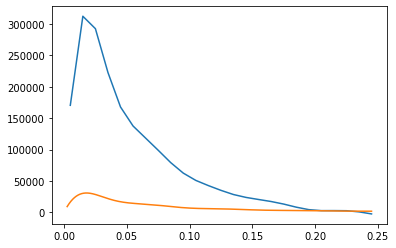

In [59]:
Pk_galaxy = Pk_CLASS_PT(params, k)
Pk_linear = Pk_lin(H0, ombh2, omch2, As, ns, z, k)
plt.plot(k, Pk_galaxy[0])
plt.plot(Pk_linear[:,0], Pk_linear[:,1])
#plt.yscale("log")

(array([], dtype=int64), array([], dtype=int64))


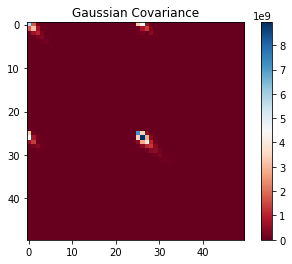

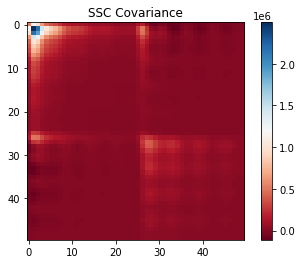

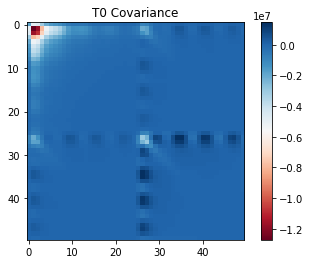

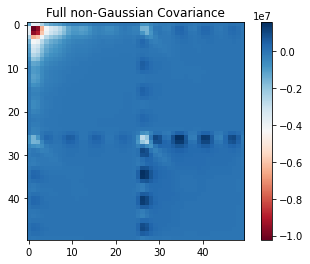

In [60]:
print(np.where(np.isnan(CovaG + covaSSCmult + covaT0mult)))
# covaT0mult_1 = covaT0mult
# idx = np.where(np.isnan(CovaG + covaSSCmult + covaT0mult))
# covaT0mult_1[idx] = 0.

plt.figure()
plt.title("Gaussian Covariance")
plt.imshow(CovaG, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.title("SSC Covariance")
plt.imshow(covaSSCmult, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.title("T0 Covariance")
plt.imshow(covaT0mult, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.title("Full non-Gaussian Covariance")
plt.imshow(covaT0mult+covaSSCmult, cmap="RdBu")
cbar = plt.colorbar()

Gaussian Covariance is NOT positive-definite!
Gaussian + SSC Covariance is NOT positive-definite!
Gaussian + SSC + T0 Covariance is NOT positive-definite!
1


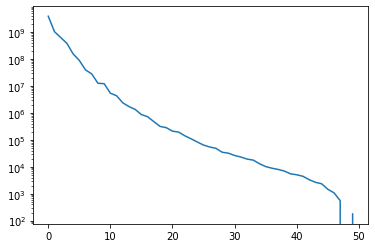

In [50]:
try:
    L = np.linalg.cholesky(CovaG)
except np.linalg.LinAlgError as err:
    print("Gaussian Covariance is NOT positive-definite!")
try:
    L = np.linalg.cholesky(CovaG + covaSSCmult)
except np.linalg.LinAlgError as err:
    print("Gaussian + SSC Covariance is NOT positive-definite!")
try:
    L = np.linalg.cholesky(CovaG + covaSSCmult + covaT0mult)
    print("Full Covariance matrix is positive definite :)")
except np.linalg.LinAlgError as err:
    print("Gaussian + SSC + T0 Covariance is NOT positive-definite!")
    
eig, v = np.linalg.eig(CovaG + covaSSCmult + covaT0mult)
print(len(eig[(eig <= 0)]))
plt.plot(range(CovaG.shape[0]), eig)
plt.yscale("log")

In [ ]:
# # iterage kmin and kmax a bunch of times to try finding a combo that results in positive definitness
# # # This cell takes around a day to run!
# kmin=np.linspace(0.005, 0.15, 50)
# kmax = .25
# for i in range(40, len(kmin)):
#     k = np.linspace(kmin[i], kmax, 40)
#     CovaG, covaT0mult, covaSSCmult = CovAnalytic(pgg, H0, Omega_m, ombh2, omch2, As, z, b1, b2, b3, be, g2, g3, g2x, g21, k)
#     try:
#         L = np.linalg.cholesky(CovaG + covaSSCmult + covaT0mult)
#         print("Full Covariance matrix is positive definite! kmin =", kmin[i], "kmax =", kmax)
#         print(len(np.where(np.isnan(CovaG + covaSSCmult + covaT0mult))), "total NaN values")
#     except np.linalg.LinAlgError as err:
#         print("Nope!, kmin =", kmin[i], "kmax =", kmax)

In [ ]:
# Cell to investigate specific call of trisp() that is misbehaving
pdata, s8 = Pk_lin(H0, ombh2, omch2, As, z, k)
Plin=InterpolatedUnivariateSpline(pdata[:,0], Dz(z, Omega_m)**2*b1**2*pdata[:,1])

l1, l2, k1, k2 = 0, 2, 0.20916666666666667, 0.20916666666666667
#l1, l2, k1, k2 = 0, 2, k[10], k[10]

T0.InitParameters([b1,be,g2,b2,g3,g2x,g21,b3])
T0.l1=l1; T0.l2=l2
expr = i44*(Plin(k1)**2*Plin(k2)*T0.ez3(k1,k2) + Plin(k2)**2*Plin(k1)*T0.ez3(k2,k1))\
       +8*i34*Plin(k1)*Plin(k2)*T0.e34o44_1(k1,k2)

temp = (quad(trispIntegrand, -1, 1,args=(k1,k2,Plin), limit=100)[0]/2. + expr)/i22**2
#y, abserr, infodict = quad(trispIntegrand, -1, 1,args=(k1,k2,Plin), limit=100, full_output=1)
print(temp)

x = np.linspace(-1, 1., 50)
y = np.zeros(50)
for i in range(50):
    y[i] = trispIntegrand(x[i], k1, k2, Plin)

print(y)
plt.plot(x, y)
# do a trapz integral to compare results
temp2 = (np.trapz(y=y, x=x) /2. + expr)/i22**2
print(temp2)

In [ ]:
u12 = -1.
t = (8*i44*(Plin(k1)**2*T0.e44o44_1(u12,k1,k2) + Plin(k2)**2*T0.e44o44_1(u12,k2,k1))\
            +16*i44*Plin(k1)*Plin(k2)*T0.e44o44_2(u12,k1,k2)\
             +8*i34*(Plin(k1)*T0.e34o44_2(u12,k1,k2)+Plin(k2)*T0.e34o44_2(u12,k2,k1))\
            +2*i24*T0.e24o44(u12,k1,k2))\
            *Plin(np.sqrt(k1**2+k2**2+2*k1*k2*u12))
print((2*be*(7 + 3*be)*(2*k2**2 + 4*k1*k2*u12 + k1**2*(-1 + 3*u12**2)))/(21.*(k1**2 + k2**2 + 2*k1*k2*u12)))
print((21.*(k1**2 + k2**2 + 2*k1*k2*u12)))